In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential


In [3]:
# re-size all the images to this
SIZE = 240

train_path = '/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition-20221108T101958Z-001/Masked Face Recognition/MainDataset'
# valid_path = '/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition/database/Test'


In [58]:
# Training data and labels into respective lists
train_images = []
train_labels = []
training_data = []
prev=0

for directory_path in glob.glob(os.path.join(train_path, "*")):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path)       
        img = cv2.resize(img, (SIZE,SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        training_data.append([train_images,train_labels])
    print(len(train_images)-prev)
    prev=len(train_images)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
training_data = np.array(training_data)

Emma Watson
50
Billie Eilish
44
Alia Bhatt
50
Daniel Radcliffe
50
Darshan Raval
46
Aishwarya Rai
49
Gal Gadot
48
Honey Singh
45
Kaley Cuoco
49
Hrithik Roshan
47
Sharukh Khan
47
Mr. Bean
46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
training_data = np.array(training_data,dtype=object)

In [10]:
len(train_labels)

571

In [ ]:
type(train_images[0])

numpy.ndarray

In [ ]:
# type(validation_data[0])

In [ ]:
test_images = []
test_labels = []
validation_data = []

for directory_path in glob.glob(os.path.join(valid_path,"*")):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
        validation_data.append([train_images,train_labels])

test_images = np.array(test_images)
test_labels = np.array(test_labels)
# validation_data = np.array(validation_data)

In [ ]:
test_labels

In [59]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=45)

In [12]:
print(len(train_labels))
print(len(test_labels))

399
172


In [60]:
#Encode labels from text to integers.
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)
encoder.fit(test_labels)
test_labels_encoded = encoder.transform(test_labels)

In [ ]:
test_labels_encoded

array([ 4,  7,  0,  4, 10,  4,  8,  8,  4, 10,  7, 10,  4,  9,  7,  0,  4,
        5,  3,  9,  4,  0,  9,  2,  1,  9,  1,  8,  7,  4,  8,  6,  0,  6,
        5,  3,  6,  1,  9,  6,  3,  7,  7,  8,  5,  6,  2,  2,  3, 10,  9,
        6,  8,  7,  9,  2,  5,  3,  2,  9,  6,  4,  0,  1,  6,  1,  5,  8,
        7, 10,  9,  1,  0,  4,  6,  1,  7, 10,  6,  1,  1,  5,  9,  4,  1,
        8,  3,  2,  1,  7,  3,  3,  3, 10,  2,  4,  6,  8,  4,  6,  5,  5,
        8,  4,  7,  8,  7,  8,  8,  7,  4,  4,  6,  2,  6,  1,  2,  2,  9,
        0,  1,  4, 10, 10,  1,  2,  4,  6,  5,  0,  5])

In [ ]:
#Inverse transform to get original label back. 
for i in range (0,11):
  print(i," ",encoder.inverse_transform([i]))

0   ['Aishwarya Rai']
1   ['Alia Bhatt']
2   ['Billie Eilish']
3   ['Daniel Radcliffe']
4   ['Darshan Raval']
5   ['Emma Watson']
6   ['Gal Gadot']
7   ['Honey Singh']
8   ['Hrithik Roshan']
9   ['Kaley Cuoco']
10   ['Mr. Bean']


In [61]:
train_images = np.array(train_images).reshape(-1,SIZE,SIZE,3)
train_images=np.array(train_images)
train_images.shape

(428, 240, 240, 3)

In [62]:
train_labels=np.array(train_labels)
train_labels.shape

(428,)

In [63]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [57]:
print('x_train       ',len(x_train),"         ",x_train.shape)
print('y_train       ',len(y_train),"         ",y_train.shape)
print('x_test       ',len(x_test),"         ",x_test.shape)
print('y_test       ',len(y_test),"         ",y_test.shape)

x_train        399           (399, 240, 240, 3)
y_train        399           (399,)
x_test        172           (172, 240, 240, 3)
y_test        172           (172,)


In [ ]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot= to_categorical(y_test)

In [64]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        brightness_range=[0.5,1.0],
                        horizontal_flip=True)

In [ ]:
print(len(y_test))
print(len(y_train))

143
428


In [ ]:
len(os.listdir(train_path))

12

In [65]:
# Loading model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [66]:
# vgg16.output.shape
type(vgg16.layers[0])

keras.engine.input_layer.InputLayer

In [67]:
for layer in vgg16.layers:
    layer.trainable = False

In [69]:
flatten = Flatten()(vgg16.output)
dense1 = Dense(192,activation='relu')(flatten)
dense2 = Dense(48,activation='relu')(dense1)
# dense3 = Dense(24,activation='relu')(dense2)
prediction = Dense(len(os.listdir(train_path)), activation='softmax')(dense2)

model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
model.summary()

In [70]:
# tell the model what cost and optimization method to use
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [71]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [72]:
result = model.fit(data_generator.flow(x_train,y_train,batch_size=16),
                   validation_data=(x_test,y_test),
                   epochs = 150, callbacks = [callback])

Epoch 1/150
27/27 [==============================] - 11s 307ms/step - loss: 15.3093 - accuracy: 0.1145 - val_loss: 2.6861 - val_accuracy: 0.1538
Epoch 2/150
27/27 [==============================] - 7s 255ms/step - loss: 2.3943 - accuracy: 0.1659 - val_loss: 2.2769 - val_accuracy: 0.1399
Epoch 3/150
27/27 [==============================] - 7s 256ms/step - loss: 2.1947 - accuracy: 0.1963 - val_loss: 2.4277 - val_accuracy: 0.1538
Epoch 4/150
27/27 [==============================] - 7s 256ms/step - loss: 2.0909 - accuracy: 0.2453 - val_loss: 2.3536 - val_accuracy: 0.2308
Epoch 5/150
27/27 [==============================] - 7s 258ms/step - loss: 1.9881 - accuracy: 0.2897 - val_loss: 2.3424 - val_accuracy: 0.2448
Epoch 6/150
27/27 [==============================] - 7s 266ms/step - loss: 2.0249 - accuracy: 0.2570 - val_loss: 2.1073 - val_accuracy: 0.2797
Epoch 7/150
27/27 [==============================] - 7s 262ms/step - loss: 1.9728 - accuracy: 0.3107 - val_loss: 2.1854 - val_accuracy: 0.20

In [89]:
model.save('/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition-20221108T101958Z-001/Masked Face Recognition/5model_vgg16.h5')

In [73]:
model1=model

In [ ]:
from tensorflow.keras.models import load_model
model1=load_model('/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition-20221108T101958Z-001/Masked Face Recognition/5model_vgg16.h5')

In [74]:
y_pred_prob = model1.predict(test_images)

5/5 [==============================] - 1s 179ms/step


In [ ]:
y_pred_prob

In [75]:
import numpy as np
y_pred = np.argmax(y_pred_prob, axis=1)

In [ ]:
y_pred.shape

(143,)

In [ ]:
y_pred

In [76]:
y_pred = encoder.inverse_transform(y_pred)

In [ ]:
y_pred

In [90]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))

Accuracy =  0.8531468531468531


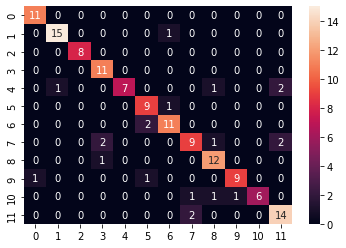

In [79]:
#Confusion Matrix - accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True)

In [91]:
# evaluate the model
_, train_acc = model1.evaluate(x_train, y_train, verbose=0)
_, test_acc = model1.evaluate(x_test, y_test, verbose=0)
print('Train: %f, Test: %f' % (train_acc, test_acc))

Train: 0.988318, Test: 0.853147


In [95]:
from sklearn import metrics
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred, average='weighted')
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(test_labels, y_pred)
print('Cohens kappa: %f' % kappa)

Accuracy: 0.853147
Precision: 0.853147
Recall: 0.853817
F1 score: 0.850205
Cohens kappa: 0.839085


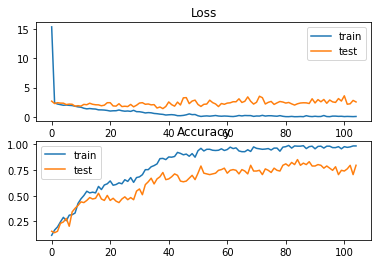

In [94]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(result.history['loss'], label='train')
pyplot.plot(result.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(result.history['accuracy'], label='train')
pyplot.plot(result.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

1/1 [==============================] - 1s 702ms/step
The prediction for this image is:  ['Sharukh Khan']
The actual label for this image is:  Sharukh Khan


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


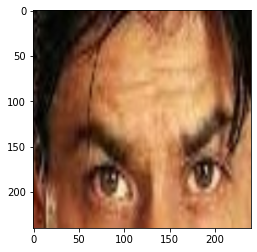

In [96]:
# For selected images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
# img = 
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
pred=model1.predict(input_img)
pred = np.argmax(pred, axis=1)
pred = encoder.inverse_transform([pred])
print("The prediction for this image is: ", pred)
print("The actual label for this image is: ", test_labels[n])